## Data analysis code 

In [77]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, sosfiltfilt, sosfreqz

## Define functions for Gaussian fitting

In [2]:
def gaussian(p,x):
    return p[0]/(p[1]*(2*np.pi)**.5)*np.exp(-.5*(x-p[2])**2/(p[1]**2))

#p[0]=multiplicative const
#p[1]=std
#p[2]=mean

def residual(p,x,y,dy):
    return (gaussian(p,x)-y)/dy

In [3]:
def gaussian_fit(counts,probability,probability_uncertainty,p0,plotting_values,show_details):
    ## Implement Gaussian fit
    index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max = plotting_values
    counts_for_gaussian=counts[index_Start:index_End]
    probability_for_gaussian=probability[index_Start:index_End]
    probability_uncertainty_for_gaussian=probability_uncertainty[index_Start:index_End]
    pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args = (counts_for_gaussian, probability_for_gaussian, 
                                                                          probability_uncertainty_for_gaussian), full_output=1, maxfev=5000)
    ## Plot data and fit
    if cov is None:
        print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5) 
            #In DarkFrameHistogramFit_polished.ipynb this plots only in the fitted range counts_for_gaussian, but this shouldn't matter if we plot it over all data points.
        x = np.linspace(Plotfit_min,Plotfit_max,1000)
        ax.plot(x, gaussian(p0, x), 'b-', label = 'Guess')
        ax.legend()
        ax.set_title('Gaussian Fit')
        ax.set_xlabel('AD count')
        ax.set_ylabel('Probability')
        ax.set_yscale('log')
        ax.set_xlim([Dataplot_min,Dataplot_max])
        ax.grid()
        plt.show()
    else:
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        if show_details:
            # print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
            print('Fit Converged')
            chisq = sum(info['fvec']*info['fvec'])
            dof = abs(len(counts_for_gaussian)-len(pf))
            print('Converged with chi-squared', chisq)
            # print('Number of degrees of freedom, dof =',dof)
            print('Reduced chi-squared', chisq/dof)
            print('Inital guess values:')
            print('  p0 =', p0)
            print('Best fit values:')
            print('  pf =', list(pf))
            print('Uncertainties in the best fit values:')
            print('  pferr =', pferr)
            print("5 sigma threshold is", pf[2]+pf[1]*5, "with uncertainty", pferr[2]+pferr[1]*5)
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111)
            ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5)
            x = np.linspace(Plotfit_min,Plotfit_max,1000) #plot fitted curve
            ax.set_yscale('log')
            ax.plot(x, gaussian(pf, x), 'r-', label = 'Fit curve')
            ax.axvspan(min(counts_for_gaussian), max(counts_for_gaussian), alpha=0.4, color='red', label = 'Fitted region')
            ax.set_title('Gaussian Fit', fontsize=16)
            ax.set_xlabel('AD count', fontsize=16)
            ax.set_ylabel('Probability', fontsize=16)
            ax.grid()
            ax.legend(loc=3)
            ax.set_xlim([Dataplot_min,Dataplot_max])
            # ax.set_ylim([1e-6,1e-1])
            plt.tight_layout()
            plt.show()
    return pf

In [4]:
def CIC_threshold(folder_path_day, Binning, CIC_sequence, gaussian_range, guess_std=7):
## Binning = (1, 2, or 4). CIC_sequence = int. 
## gaussian_range is the. Recommended: [1520, 1550] for 1x1 binning, [1700, 1760] for 4x4 binning, 
## guess_std=7 is the initial guess of std for a normal distribution fit.
## Get threshold values from data when shutter is closed (if we blackened inside well, you can just use the 0mW data)
    all_images = np.full((300, int(512/Binning), int(512/Binning)), np.NaN)
    folder_path = folder_path_day + '/'+r'/%.4i'%CIC_sequence
    for count_b, filename in enumerate(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images[count_b, :, :] = image_data
    
    background_counts = all_images.ravel()
    background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
    plt.close()
    counts=background_bins[1][:-1]+.5
    counts=counts.astype(int)
    
    # #Plot histogram for total 300 pics
    # plt.figure(3)
    # plt.grid()
    # plt.xlabel('AD Count', fontsize=16)
    # plt.ylabel('Number of Pixels', fontsize=16)
    
    # # Plot error rate 
    # plt.figure(4)
    # plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
    # plt.xlabel('Threshold', fontsize=16)
    # plt.ylabel('Error rate', fontsize=16)
    # plt.show()

    # Get threshold
    probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
    probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
    peak_probability = np.max(probability)
    peak_index = np.argmax(probability)
    peak=counts[peak_index]
    
    #Select x region where you want to fit the gaussian: this can be arbirary
    [Start_gaussian, End_gaussian] = gaussian_range
    
    index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
    index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian
    
    # Select x region where you want to plot the fitted gaussian: this must include the above region
    Plotfit_min = counts[index_Start] -7
    Plotfit_max = counts[index_End] +7
    
    # Select x region where you want to plot the data: this must include the above region
    Dataplot_min = 1480
    Dataplot_max = 1900
    
    
    print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
    # Now apply the Gaussian fit to your histogram and plot...
    plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
    print(plotting_values)
    pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
     

# Define PC thresholds for binning=1x1, EMCCD gain=5000

In [71]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23'

[9.87013888e-02 7.00000000e+00 1.53800000e+03]
[74, 99, 1518, 1557, 1480, 1900]
Fit Converged
Converged with chi-squared 114.82734135385451
Reduced chi-squared 5.219424606993386
Inital guess values:
  p0 = [0.09870138879542992, 7, 1538]
Best fit values:
  pf = [0.09901292995732597, 7.02924430059651, 1538.436276113751]
Uncertainties in the best fit values:
  pferr = [4.0547559531174726e-05, 0.003465580505130629, 0.0032924253340459665]
5 sigma threshold is 1573.5824976167337 with uncertainty 0.02062032785969911


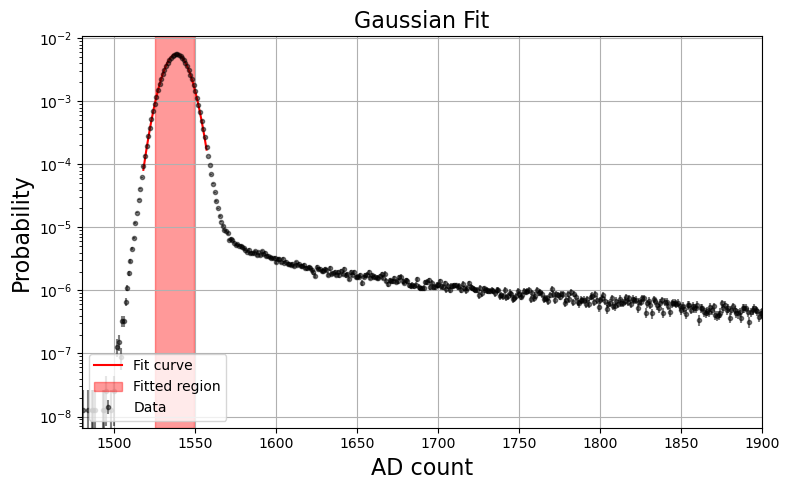

In [7]:
Binning = 1
CIC_sequence = 4
CIC_threshold(folder_path_day, Binning, CIC_sequence, [1525, 1550], guess_std=7)

In [8]:
LIF_thres=1574

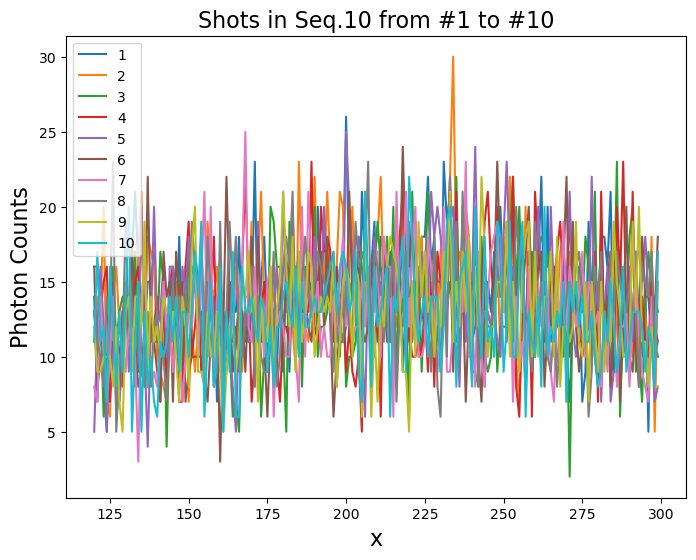

total # of photons =  23794
total_counts= 10
average # of photons =  2379.4


In [9]:
# Photon counts for each of the shots
seq = 10 #sequence number
count_b_start=1
count_b_end=10

folder_path = folder_path_day + '\\%.4i'%seq
sum_array=[] #average number of photons
fig = plt.figure(20, figsize=(8,6))
total_counts=0
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    if count_b<=count_b_end and count_b>=count_b_start:
    # if np.any(np.array([4,6,8,9,12,14,15, 17, 18])==count_b):
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<LIF_thres]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            
            plt.plot(np.arange(120,300,1),cross_section_x[120:300], label=count_b)
            sum_array.append(np.sum(cross_section_x[120:300]))
            total_counts+=1


# plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()
plt.show()

print("total # of photons = ", np.sum(sum_array))
print("total_counts=", total_counts)
print("average # of photons = ", np.sum(sum_array)/total_counts)


# FM absorption signal

In [78]:
def plot_LIF_FM(seq, folder_path_day, count_b, Binning, photon_counting_threshold, smooth_method, DC_ylim, LIF_region = False, display_pixels = False):
## Binning=(1, 2, or 4)
## smooth_method = 'no filter', 'savgol', 'lowpass', or 'both'
    LIF_range=np.arange(1,int(512/Binning),1)
    folder_path = folder_path_day + r'/%.4i'%seq
    plt.close()
    
    [count_b_start, count_b_end]=count_b
    abs_sums=[]
    fluor_sums = []
    tYAG=2
    
    # LIF
    if display_pixels == False:
        conversion = 0.016*8/5 #EMCCD pixel size=0.016mm and optical magnification=8/5 on FOV
    else:
        conversion = 1
    x=np.arange(int(512/Binning))
    # Setup subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Unpack individual axes
    ax_abs1 = axes[0, 0]
    ax_abs2 = axes[0, 1]
    ax_abs3 = axes[1, 0]
    ax_lif  = axes[1, 1]
    abs_traces = ['Absorption', 'Absorption2', 'Absorption3']
    abs_axes = [ax_abs1, ax_abs2, ax_abs3] 
    abs_labels = ['Absorption (I)', 'Absorption (Q)', 'Absorption (DC)']
    
    last_file = ''
    for count_b, filename in enumerate(os.listdir(folder_path)): 
        file_path = os.path.join(folder_path, filename)
        # print(filename)
        if count_b<=count_b_end and count_b>=count_b_start: #POINT WE STOPPED TAKING DATA...
            if os.path.exists(file_path):
                last_file = count_b
                pass
            else:
                continue
            with h5py.File(file_path, 'r') as file:
                ## Absorption ############
                for i, (trace_name, ax_abs) in enumerate(zip(abs_traces, abs_axes)):
                    analog_data = file[f'data/traces/{trace_name}'][:]
                    times, values = zip(*analog_data)
                    # Convert to NumPy arrays if needed
                    time_ms = np.array(times)*1000
                    values = np.array(values)
        
                    #collect useful indices. Could have also done times.searchsorted()
                    trigger_index = np.searchsorted(time_ms,tYAG)
                    beforeYAG_index = np.searchsorted(time_ms,1.95) # hardcoded values are on the absorption data timeframe.
                    after_abs_index = np.searchsorted(time_ms,10)
                    end_index = np.searchsorted(time_ms,15)
                
                    #Remove linear drift and find offset 
                    fit_time = np.concatenate((time_ms[:beforeYAG_index],time_ms[after_abs_index:end_index]))
                    fit_data = np.concatenate((values[:beforeYAG_index],values[after_abs_index:end_index]))
                    popt, _ = curve_fit(line_func, fit_time, fit_data, p0=[(fit_data[-1]-fit_data[0])/(time_ms[-1]-time_ms[0]),fit_data.mean()])
                    slope=popt[0]
                    intercept=popt[1]
                    flat_data =  values - line_func(time_ms,slope,intercept)
                    offset = flat_data[:trigger_index].mean()
        
                    #Plot on absorption subplot
                    ax_abs.plot(time_ms-tYAG, flat_data, label=f'#{count_b}')
            
                    #Sum of absorption signals
                    dt=(time_ms[1]-time_ms[0])
                    abs_sum = np.sum(abs(flat_data[time_ms.searchsorted(tYAG+0.05):time_ms.searchsorted(tYAG+6)]))*dt
                    # -------- PLOT FORMATTING --------
                    ax_abs.set_title(f'{abs_labels[i]} in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
                    ax_abs.set_xlabel('Time [ms]', fontsize=14)
                    ax_abs.set_ylabel(abs_labels[i], fontsize=14)
                    # ax_abs.legend(fontsize=8)
                    # ----------------------------------
                ####################################
    
    
                
                ## LIF ########################
                # get x-cross section for every shot in the sequence
                image_data = file['images/camera/fluorescence/frame'][:]
                image_data[image_data<photon_counting_threshold]=0
                cross_section_x = np.count_nonzero(image_data, axis=0)
                cross_section_x=cross_section_x[LIF_range]
    
                filter_freq = 0.05
                if smooth_method == 'lowpass': #Smoothing with lowpass filter
                    N = len(LIF_range)
                    delta_s = (LIF_range[1]-LIF_range[0])
                    fs = np.round(1/delta_s,4)
                    lowcut = filter_freq
                    order=2
                    filtered_data = butter_lowpass_filter(cross_section_x,lowcut,fs,order=order)
                elif smooth_method == 'savgol': #Smoothing with polynomial filter
                    filtered_data = smooth(cross_section_x,window=20,poly_order=3)
                elif smooth_method == 'both': #Smoothing with both filters
                    N = len(LIF_range)
                    delta_s = (LIF_range[1]-LIF_range[0])
                    fs = np.round(1/delta_s,4)
                    lowcut = filter_freq
                    order=2
                    filt1 = butter_lowpass_filter(cross_section_x,lowcut,fs,order=order)
                    filt2 = smooth(cross_section_x,window=25,poly_order=3)
                    filtered_data = np.array([filt1,filt2]).T
                else: # No filter
                    filtered_data = cross_section_x
                    
                #Plot on LIF subplot
                ####Conversion###
                filtered_data = np.log1p(-filtered_data/512.0)/np.log(511.0/512.0)
                #################
                pixel_mm = LIF_range * conversion
                ax_lif.plot(pixel_mm, filtered_data, label=f'#{count_b}')
                if LIF_region:
                    fluor_sum = np.sum((filtered_data[x.searchsorted(LIF_region[0]/conversion):x.searchsorted(LIF_region[1]/conversion)]-LIF_region[2]))
                    abs_sums.append(abs_sum)
                    fluor_sums.append(fluor_sum)
                ####################################
    
    if LIF_region:
        ax_lif.axvspan(LIF_region[0], LIF_region[1], color='y', alpha=0.5, lw=0)
        
    
    
    # -------- PLOT FORMATTING --------
    # Absorption Plot
    for ax_abs in abs_axes:
        ax_abs.axvline(x=0, color='r', linestyle='--')
        ax_abs.text(0.4, ax_abs.get_ylim()[1] * 0.85 + ax_abs.get_ylim()[0] * 0.15, 'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')
        x_range = (0 - tYAG, 15 - tYAG)
        ax_abs.set_xlim(x_range[0], x_range[1])
        if ax_abs == ax_abs3:
            ax_abs.set_ylim(DC_ylim) 
            for txt in ax_abs.texts:
                txt.remove()
            ax_abs.text(0.4, -1.5 * 0.15 + ax_abs.get_ylim()[1] * 0.85, 'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')
    
    
    ## legend, comment ouf if you don't need ###
    # --- Collect legend handles and labels from all axes ---
    handles = []
    labels = []
    for ax in abs_axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    # Remove duplicates
    legend_dict = dict(zip(labels, handles))
    unique_labels = list(legend_dict.keys())
    unique_handles = list(legend_dict.values())
    # --- Add global legend to the figure ---
    # fig.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, title='Shot #')
    ####################################
    
    # LIF Plot
    ax_lif.set_title(f'LIF in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
    if not display_pixels:
        ax_lif.set_xlabel('Distance Along Beam (mm)', fontsize=12)
    else:
        ax_lif.set_xlabel('EMMCD H Pixel (summing V)', fontsize=12)
    ax_lif.set_ylabel('Photon Counts', fontsize=12)
    ax_lif.set_xlim(0 + 48/Binning * conversion, (512 - 48)/Binning * conversion)
    # ax_lif.set_ylim(-10,50)
    
    plt.tight_layout(rect=[0, 0, 1, 1])
    
    # ----------------------------------
    
    
    # -------- LIF photon counts --------
    if LIF_region:
        plt.figure(3)
        abs_sums = np.array(abs_sums).T
        shot_numbers = np.arange(len(fluor_sums))
        plt.plot(shot_numbers,fluor_sums,'ko',label='all abs')
        plt.xlabel('Shot number', fontsize=14)
        plt.ylabel('LIF Beam Signal, BaF', fontsize=14)
        plt.title('Region of Interest', fontsize=14)

        ##saving as a file############################ ##############  
        # Make sure the output directory exists
        save_dir = folder_path_day + '/PHOTONS'
        os.makedirs(save_dir, exist_ok=True) 
        
        out_filename = os.path.join(save_dir,f"{seq}.txt")
        # Check if it exists
        if os.path.exists(out_filename):
            print(f"{out_filename} already exists, overwriting...")
            status = "overwritten"
        else:
            status = "saved"
        np.savetxt(out_filename, fluor_sums)
        print(f"{out_filename} {status} with {len(fluor_sums)} values.")
        print('max = ', max(fluor_sums))
        ############## ############## ############## ############## 
    plt.show()

In [79]:
def line_func(x, A, B):
    return B
    #return A*x + B
def smooth(data,window=5,poly_order=3):
    '''Function for smoothing data. Currently uses Savitzky-Golay filter,
    which fits a window of data onto a polynomial of some order, and then
    uses the polynomial to estimate the value'''
    #window value must be odd
    if window % 2 == 0:
        window+=1
    smoothed_data = savgol_filter(data, window, poly_order)
    return smoothed_data

def butter_lowpass_filter(data, lowcut, fs, order=5):
    sos = butter_lowpass(lowcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    sos = butter(order, low, analog=False, btype='lowpass', output='sos')
    return sos

C:\Users\PolyEDM\AppData\Local\Temp\ipykernel_23832\1189998362.py:59: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(line_func, fit_time, fit_data, p0=[(fit_data[-1]-fit_data[0])/(time_ms[-1]-time_ms[0]),fit_data.mean()])


C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\30.txt already exists, overwriting...
C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\30.txt overwritten with 300 values.
max =  54765.06451387172


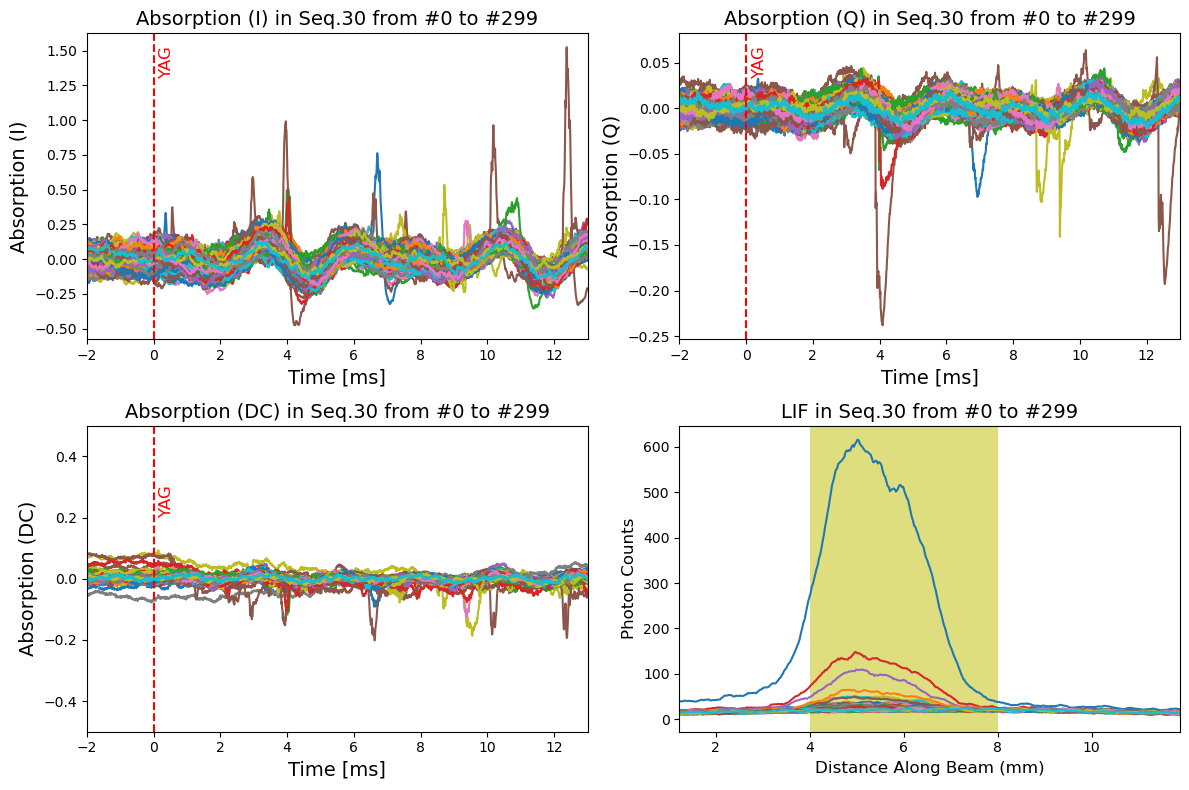

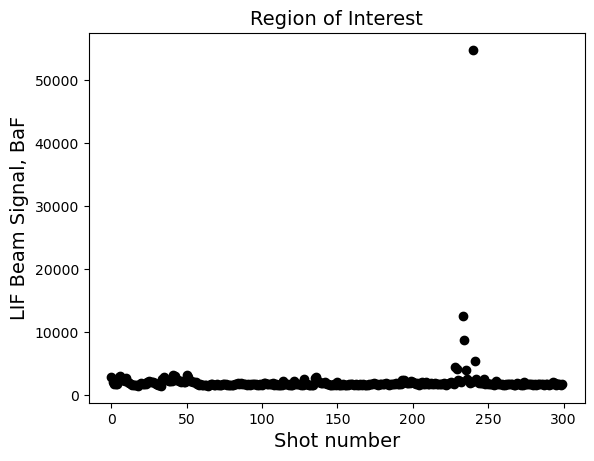

In [80]:
seq = 30 #sequence number
count_b = [0, 300]
Binning = 1
photon_counting_threshold = 1577
smooth_method = 'savgol'
DC_ylim = [-.5, .5] #for third plot
display_pixels = False
LIF_region = [3.5, 8, 10] #4mm to 7mm, background photons=10
plot_LIF_FM(seq, folder_path_day, count_b, Binning, photon_counting_threshold, smooth_method, DC_ylim, LIF_region, display_pixels)



C:\Users\PolyEDM\AppData\Local\Temp\ipykernel_23832\1832492915.py:59: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(line_func, fit_time, fit_data, p0=[(fit_data[-1]-fit_data[0])/(time_ms[-1]-time_ms[0]),fit_data.mean()])


C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\26.txt already exists, overwriting...
C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\26.txt overwritten with 100 values.


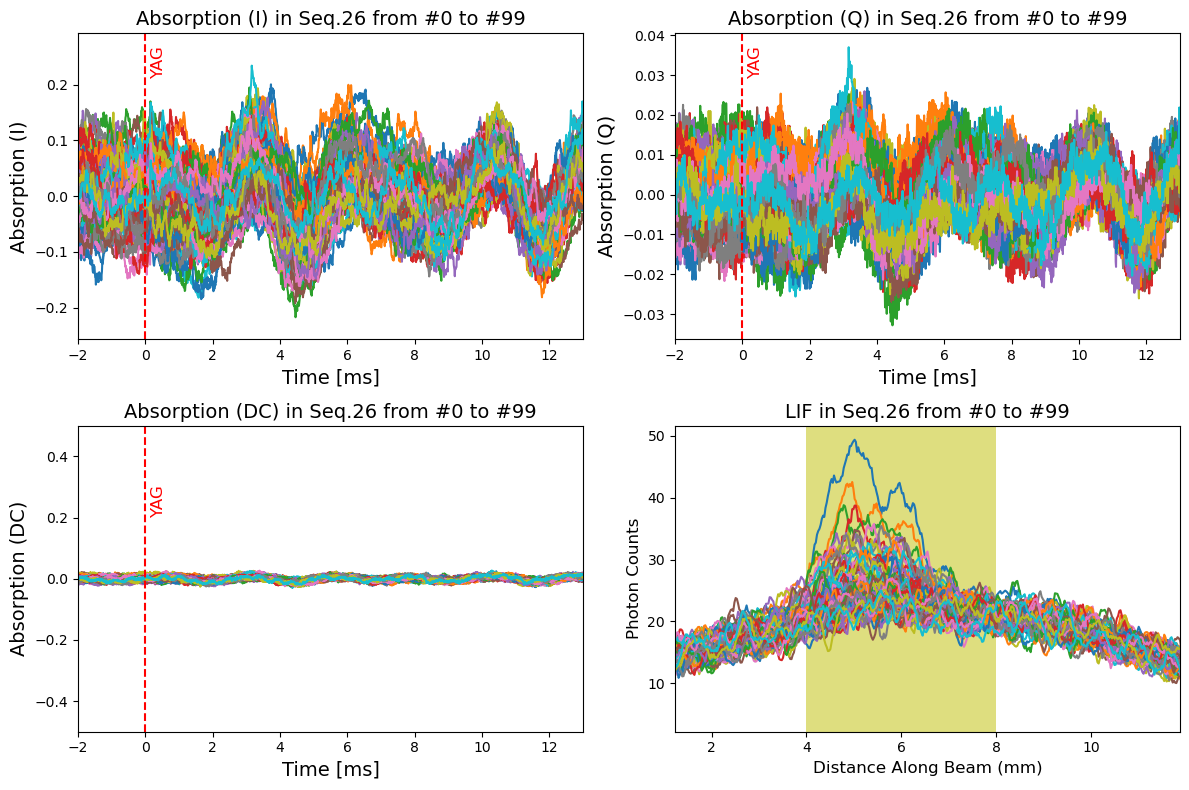

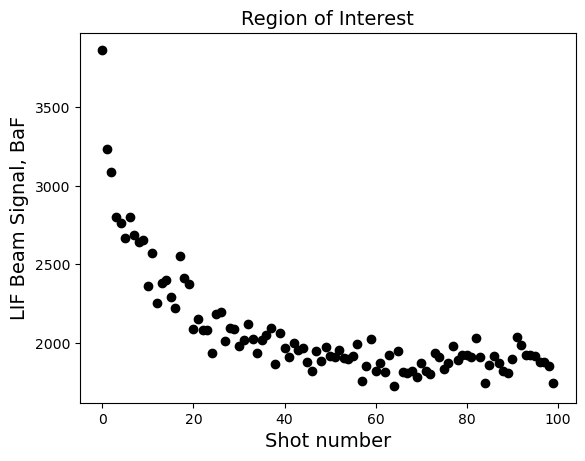

C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\27.txt already exists, overwriting...
C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\27.txt overwritten with 100 values.


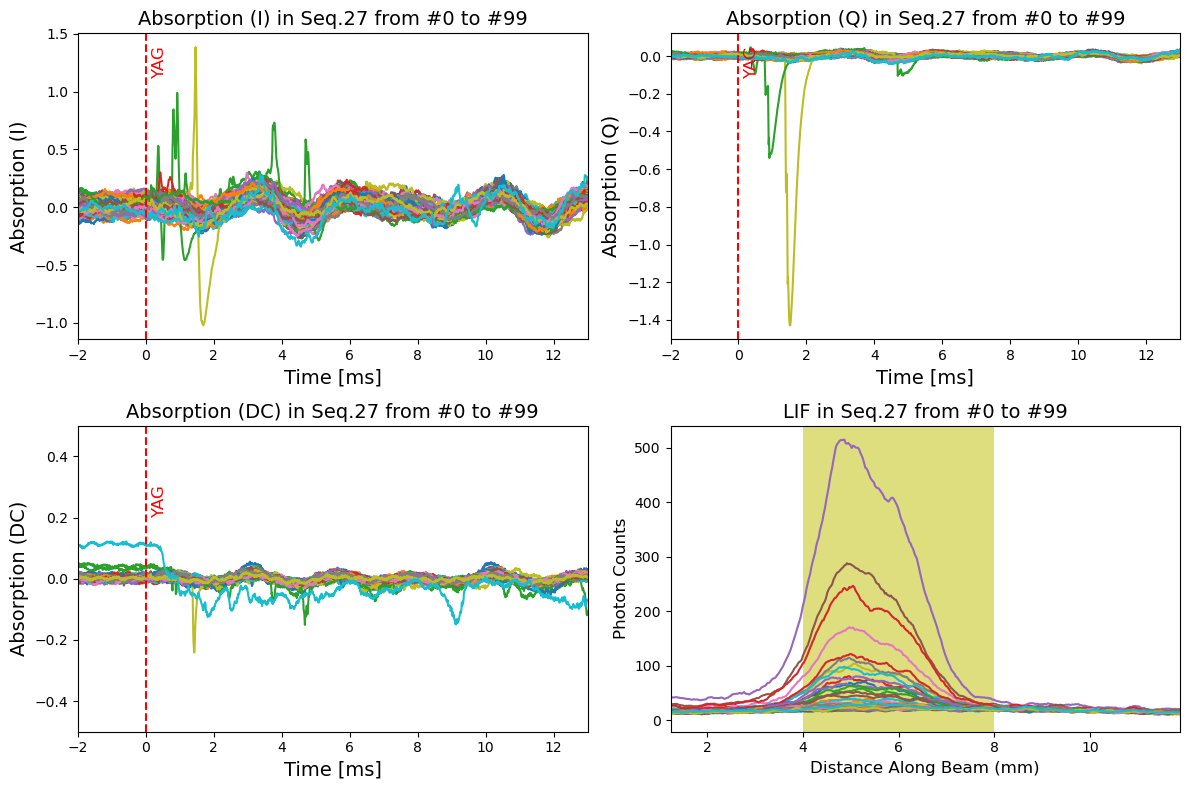

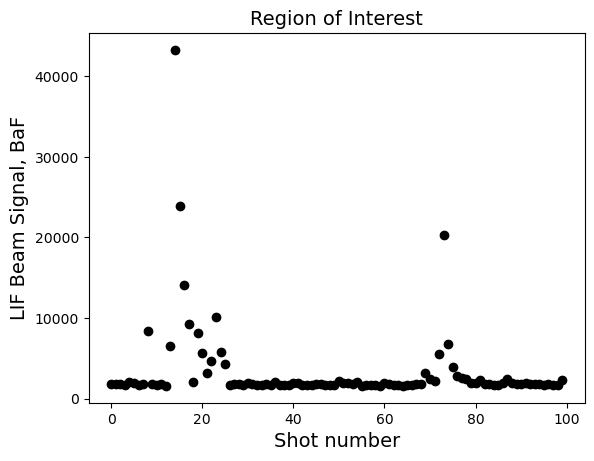

C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\28.txt already exists, overwriting...
C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\28.txt overwritten with 100 values.


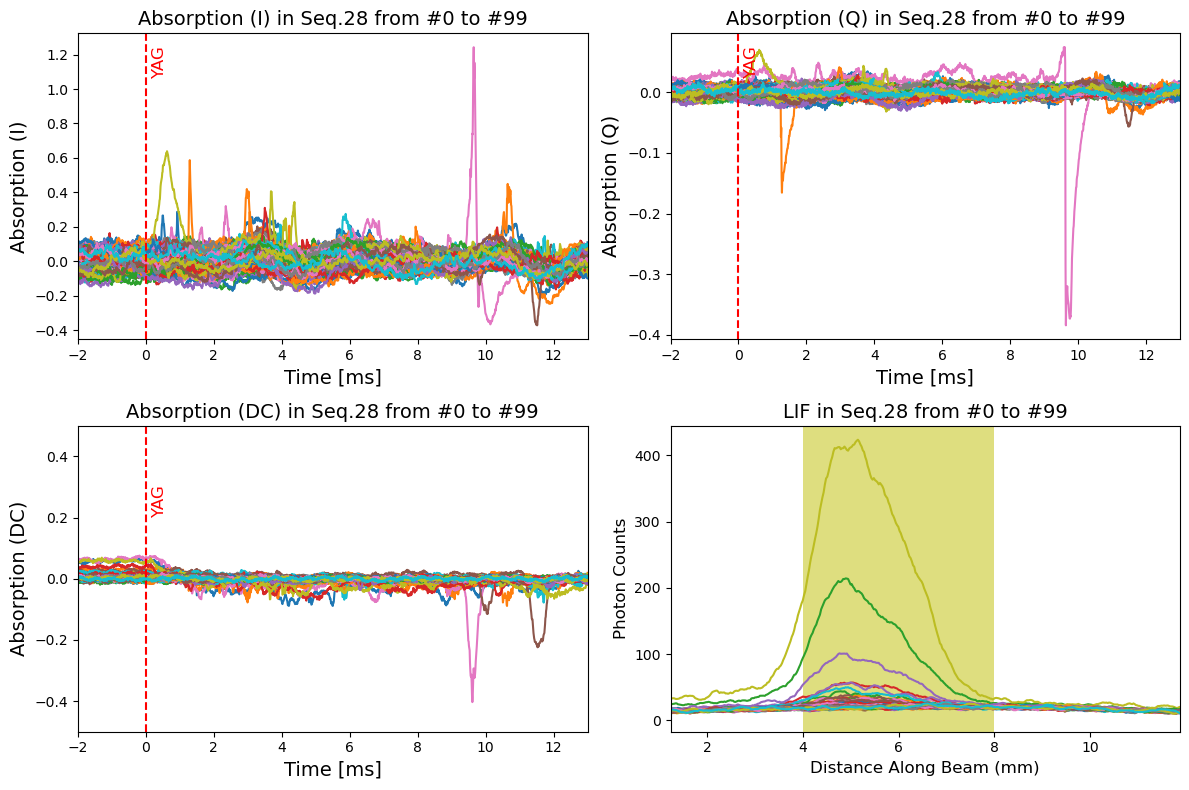

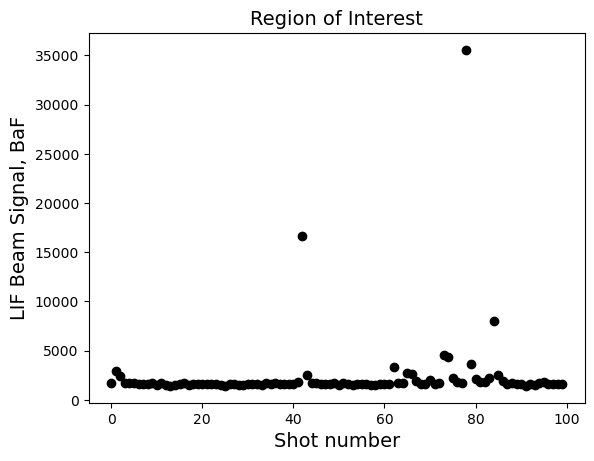

C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\29.txt already exists, overwriting...
C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\29.txt overwritten with 50 values.


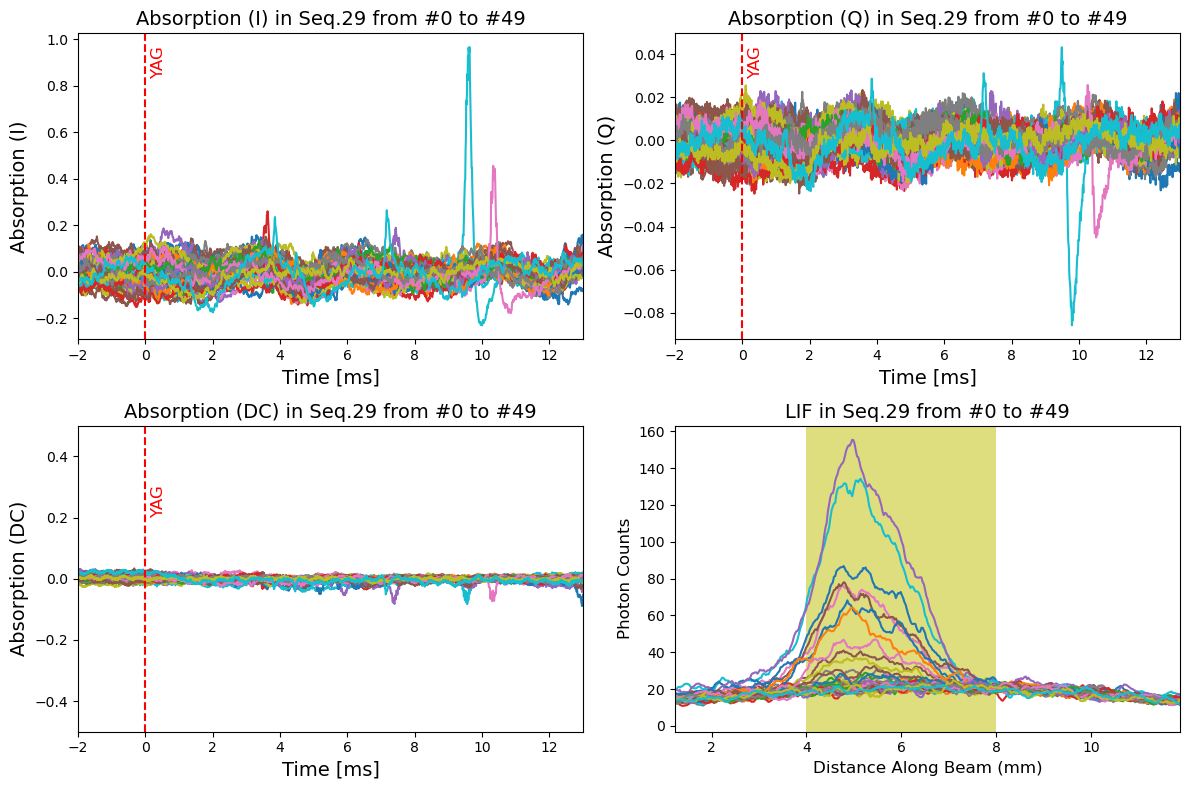

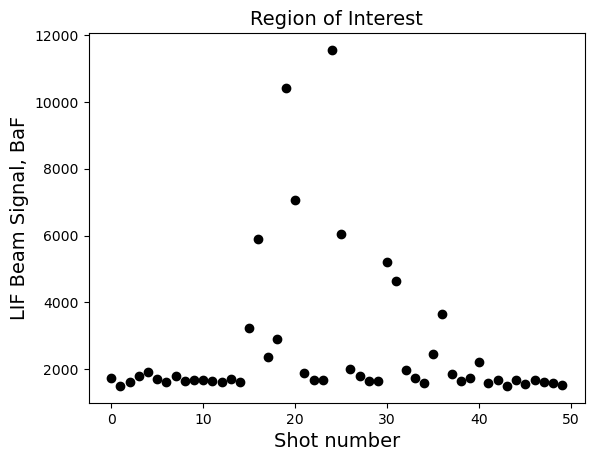

C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\30.txt already exists, overwriting...
C:\Experiments\lyman29\BaF_Fluorescence\2025\09\23/PHOTONS\30.txt overwritten with 300 values.


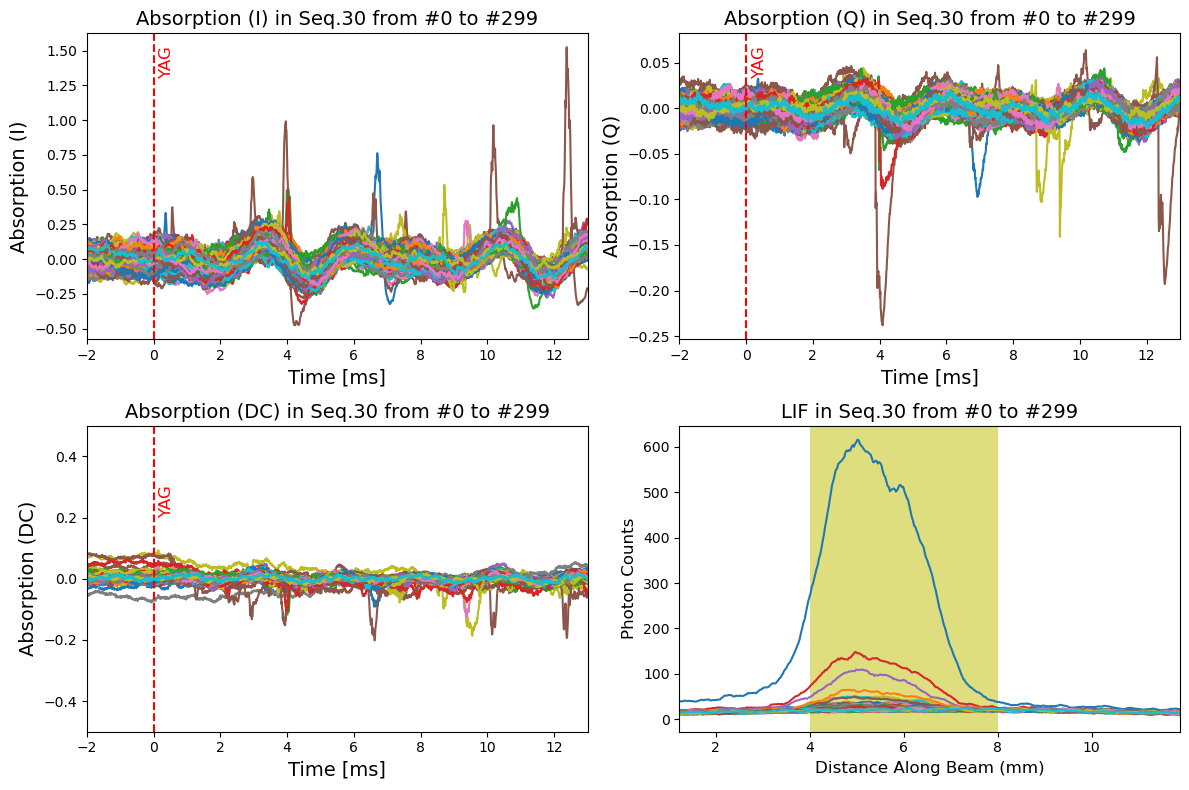

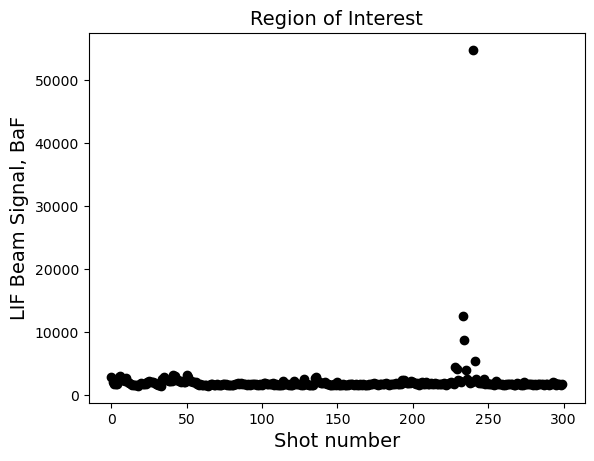

In [76]:
seqs = np.arange(26,31,1)

for seq in seqs:
    count_b = [0, 1000]
    Binning = 1
    photon_counting_threshold = 1577
    smooth_method = 'savgol'
    DC_ylim = [-.5, .5] #for third plot
    display_pixels = False
    LIF_region = [4, 8, 10] #4mm to 7mm, background photons=10
    plot_LIF_FM(seq, folder_path_day, count_b, Binning, photon_counting_threshold, smooth_method, DC_ylim, LIF_region, display_pixels)


In [219]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.optimize import curve_fit

def plot_LIF_FM_2(seq, folder_path_day, count_b, Binning, photon_counting_threshold, smooth_method, DC_ylim, LIF_region=False, display_pixels=False):
    LIF_range = np.arange(1, int(512 / Binning), 1)
    folder_path = folder_path_day + r'/%.4i' % seq
    plt.close()

    [count_b_start, count_b_end] = count_b
    abs_sums = []
    fluor_sums = []
    tYAG = 2

    conversion = 0.016 * 8 / 5 if not display_pixels else 1
    x = np.arange(int(512 / Binning))

    # Setup subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    ax_abs = axes[0]
    ax_lif = axes[1]

    abs_traces = ['Absorption', 'Absorption2']
    abs_labels = ['Absorption (I)', 'Absorption (Q)']

    # Setup colormap
    colormap = get_cmap('tab10')
    color_list = colormap.colors

    last_file = ''
    for count_b_idx, filename in enumerate(sorted(os.listdir(folder_path))):
        if count_b_idx < count_b_start or count_b_idx > count_b_end:
            continue

        file_path = os.path.join(folder_path, filename)
        if not os.path.exists(file_path):
            continue

        last_file = count_b_idx
        color_idx = (count_b_idx - count_b_start) % len(color_list)
        current_color = color_list[color_idx]

        with h5py.File(file_path, 'r') as file:
            ## Absorption
            for i, trace_name in enumerate(abs_traces):
                analog_data = file[f'data/traces/{trace_name}'][:]
                times, values = zip(*analog_data)
                time_ms = np.array(times) * 1000
                values = np.array(values)

                trigger_index = np.searchsorted(time_ms, tYAG)
                beforeYAG_index = np.searchsorted(time_ms, 1.95)
                after_abs_index = np.searchsorted(time_ms, 10)
                end_index = np.searchsorted(time_ms, 15)

                fit_time = np.concatenate((time_ms[:beforeYAG_index], time_ms[after_abs_index:end_index]))
                fit_data = np.concatenate((values[:beforeYAG_index], values[after_abs_index:end_index]))
                popt, _ = curve_fit(line_func, fit_time, fit_data,
                                    p0=[(fit_data[-1] - fit_data[0]) / (time_ms[-1] - time_ms[0]), fit_data.mean()])
                slope, intercept = popt
                flat_data = values - line_func(time_ms, slope, intercept)
                offset = flat_data[:trigger_index].mean()

                # Plotting
                ax_abs.plot(
                    time_ms - tYAG,
                    flat_data,
                    color=current_color,
                    linewidth=3 if i == 0 else 2.0,
                    label=f'#{count_b_idx}' if i == 0 else None
                )

                # Absorption sum (only once per file)
                if i == 0:
                    dt = (time_ms[1] - time_ms[0])
                    abs_sum = np.sum(abs(flat_data[
                        time_ms.searchsorted(tYAG + 0.05):time_ms.searchsorted(tYAG + 6)
                    ])) * dt

            ## LIF
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data < photon_counting_threshold] = 0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            cross_section_x = cross_section_x[LIF_range]

            filter_freq = 0.05
            if smooth_method == 'lowpass':
                N = len(LIF_range)
                delta_s = (LIF_range[1] - LIF_range[0])
                fs = np.round(1 / delta_s, 4)
                filtered_data = butter_lowpass_filter(cross_section_x, filter_freq, fs, order=2)
            elif smooth_method == 'savgol':
                filtered_data = smooth(cross_section_x, window=20, poly_order=3)
            elif smooth_method == 'both':
                N = len(LIF_range)
                delta_s = (LIF_range[1] - LIF_range[0])
                fs = np.round(1 / delta_s, 4)
                filt1 = butter_lowpass_filter(cross_section_x, filter_freq, fs, order=2)
                filt2 = smooth(cross_section_x, window=25, poly_order=3)
                filtered_data = np.array([filt1, filt2]).T
            else:
                filtered_data = cross_section_x

            pixel_mm = LIF_range * conversion
            ax_lif.plot(pixel_mm, filtered_data, label=f'#{count_b_idx}', color=current_color)

            if LIF_region:
                fluor_sum = np.sum(
                    (filtered_data[
                        x.searchsorted(LIF_region[0] / conversion):x.searchsorted(LIF_region[1] / conversion)
                    ] - LIF_region[2])
                )
                abs_sums.append(abs_sum)
                fluor_sums.append(fluor_sum)

    if LIF_region:
        ax_lif.axvspan(LIF_region[0], LIF_region[1], color='y', alpha=0.5, lw=0)

    # Absorption plot formatting
    ax_abs.axvline(x=0, color='r', linestyle='--')
    ax_abs.text(0.4, ax_abs.get_ylim()[1] * 0.85 + ax_abs.get_ylim()[0] * 0.15,
                'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')
    ax_abs.set_xlim(-tYAG, 15 - tYAG)
    ax_abs.set_title(f'Absorption in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
    ax_abs.set_xlabel('Time [ms]', fontsize=14)
    ax_abs.set_ylabel('Absorption Signal', fontsize=14)
    # ax_abs.legend(fontsize=9, title='Shot #')

    # LIF plot formatting
    ax_lif.set_title(f'LIF in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
    if not display_pixels:
        ax_lif.set_xlabel('Distance Along Beam (mm)', fontsize=12)
    else:
        ax_lif.set_xlabel('EMCCD H Pixel (summing V)', fontsize=12)
    ax_lif.set_ylabel('Photon Counts', fontsize=12)
    ax_lif.set_xlim(0 + 48 / Binning * conversion, (512 - 48) / Binning * conversion)
    # ax_lif.legend(fontsize=9, title='Shot #')

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

    # Save photon counts
    if LIF_region:
        plt.figure(3)
        abs_sums = np.array(abs_sums).T
        shot_numbers = np.arange(len(fluor_sums))
        plt.plot(shot_numbers, fluor_sums, 'ko', label='All Abs.')
        plt.xlabel('Shot number', fontsize=14)
        plt.ylabel('LIF Beam Signal, BaF', fontsize=14)
        plt.title('Region of Interest', fontsize=14)

        # Save data
        save_dir = folder_path_day + '/PHOTONS'
        os.makedirs(save_dir, exist_ok=True)
        out_filename = os.path.join(save_dir, f"{seq}.txt")
        status = "overwritten" if os.path.exists(out_filename) else "saved"
        np.savetxt(out_filename, fluor_sums)
        print(f"{out_filename} {status} with {len(fluor_sums)} values.")
        plt.show()


C:\Users\PolyEDM\AppData\Local\Temp\ipykernel_9264\3405799422.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('tab10')
C:\Users\PolyEDM\AppData\Local\Temp\ipykernel_9264\3405799422.py:61: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(line_func, fit_time, fit_data,


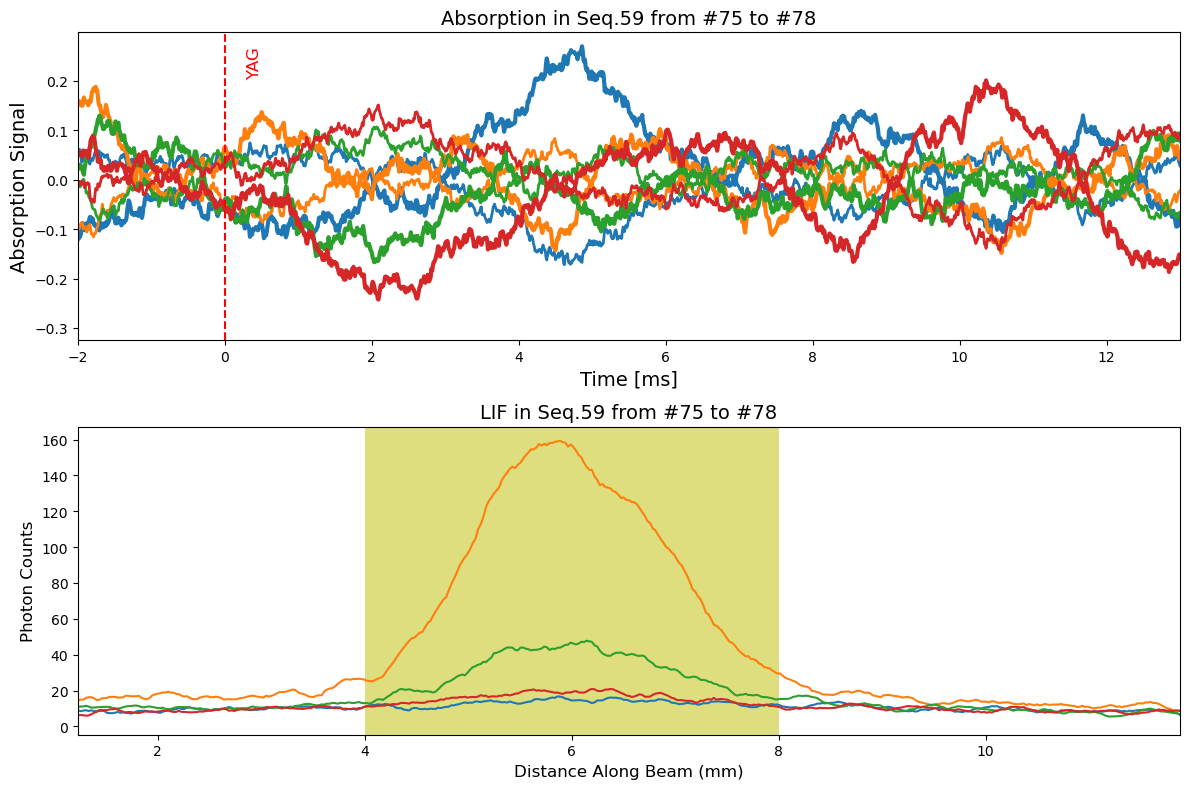

C:\Experiments\lyman29\BaF_Fluorescence\2025\09\30/PHOTONS\59.txt overwritten with 4 values.


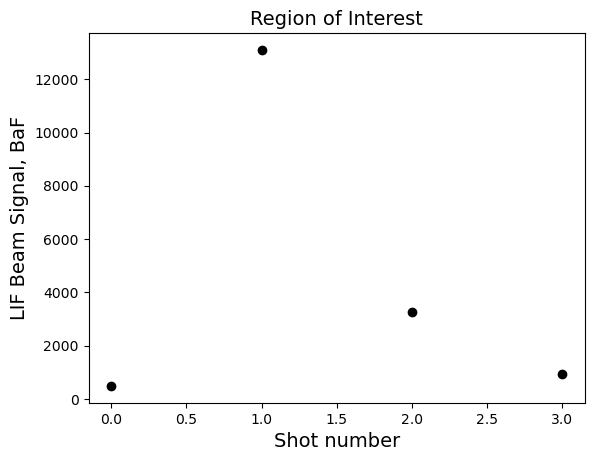

In [231]:
seq = 59 #sequence number
count_b = [75, 78]
Binning = 1
photon_counting_threshold = 1577
smooth_method = 'savgol'
DC_ylim = [-.5, .5] #for third plot
display_pixels = False
LIF_region = [4, 8, 10] #4mm to 7mm, background photons=10
plot_LIF_FM_2(seq, folder_path_day, count_b, Binning, photon_counting_threshold, smooth_method, DC_ylim, LIF_region, display_pixels)


# Histogram plot

# Define PC thresholds for binning=4x4, EMCCD gain=5000

Text(0, 0.5, 'Number of Pixels')

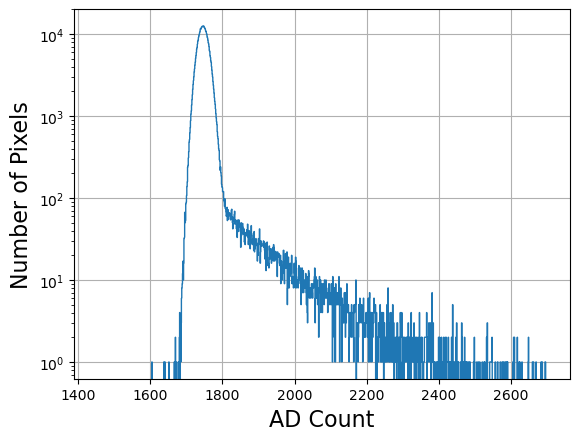

In [81]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 128, 128), np.NaN)
folder_path = folder_path_day + '\\0033'
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[4.48762549e-02 7.00000000e+00 1.74800000e+03]
[249, 309, 1693, 1767, 1480, 1900]
fit region: AD count =  1700 to  1759
Fit Converged
Converged with chi-squared 82.45325305720307
Number of degrees of freedom, dof = 57
Reduced chi-squared 1.4465482992491767
Inital guess values:
  p0 = [0.0448762549403288, 7, 1748]
Best fit values:
  pf = [0.09552030941313129, 14.859651782203198, 1746.2072424656765]
Uncertainties in the best fit values:
  pferr = [0.00021886196288268476, 0.03265753340752447, 0.04814702671178679]
5 sigma threshold is 1820.5055013766926 with uncertainty 0.21143469374940915


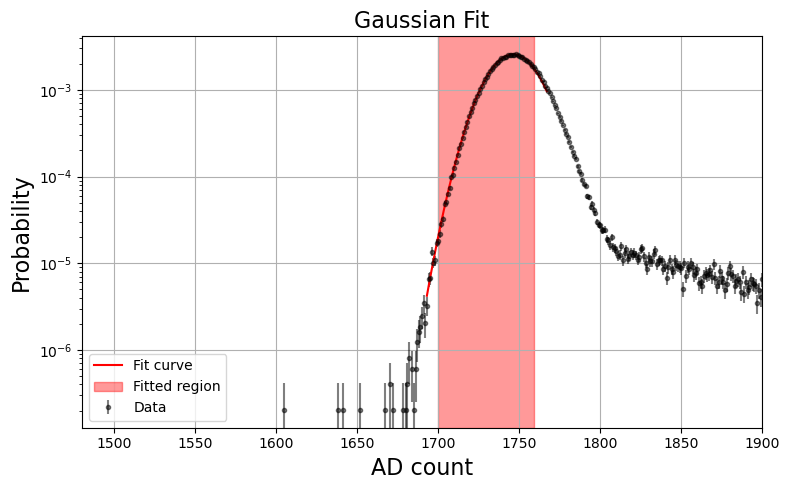

In [82]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1700
End_gaussian=1760

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +7

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

# Photon counting LIF with threshold count=1821

In [119]:
seq=42

C:\Users\PolyEDM\AppData\Local\Temp\ipykernel_20252\2363632487.py:65: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(line_func, fit_time, fit_data, p0=[(fit_data[-1]-fit_data[0])/(time_ms[-1]-time_ms[0]),fit_data.mean()])


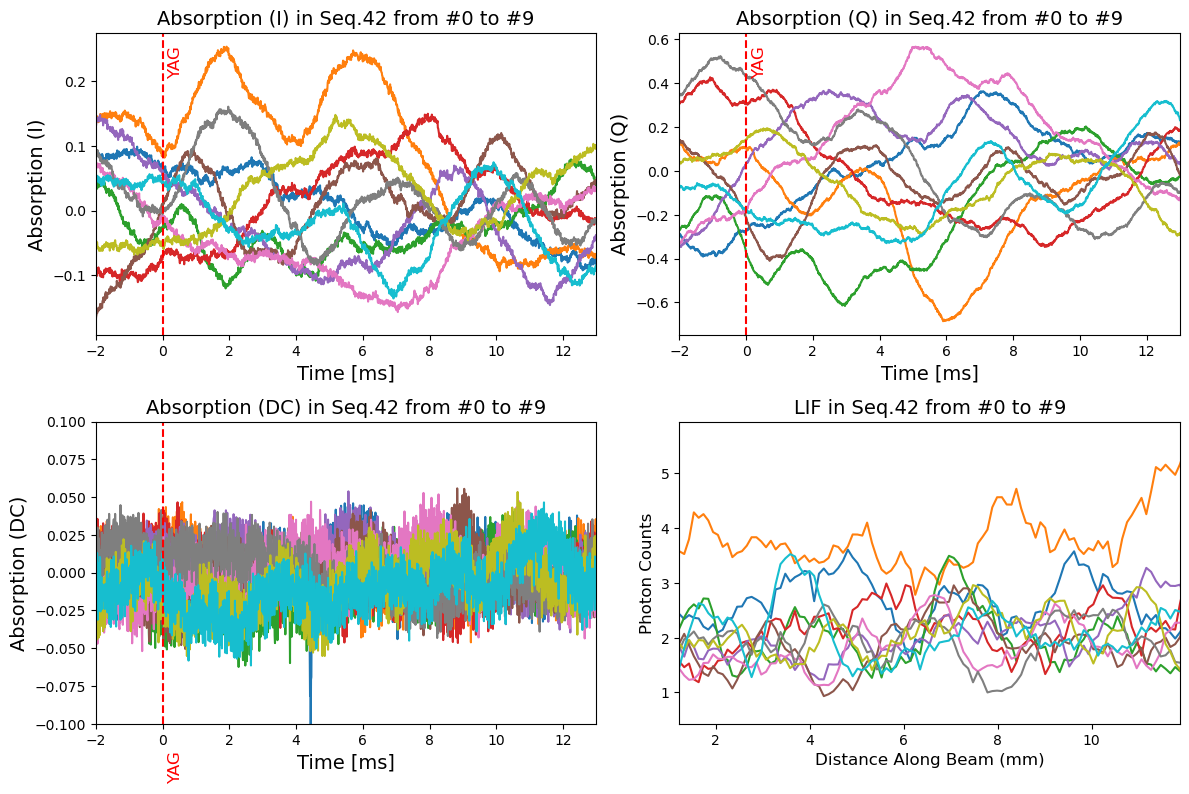

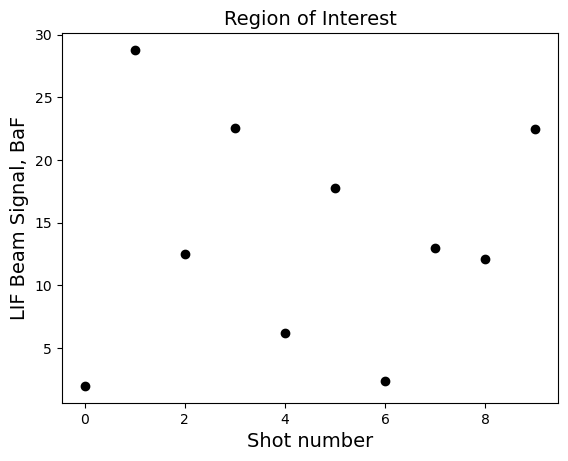

In [120]:

LIF_range=np.arange(1,128,1)
photon_counting_threshold=1821
DC_ylim=[-0.1, 0.1] #for plot 3


folder_path = folder_path_day + r'/%.4i'%seq

plt.close()

# smooth_method = 'no filter'
# smooth_method = 'lowpass'
smooth_method = 'savgol'
# smooth_method = 'both'

count_b_start=0
count_b_end=1000

abs_sums=[]
fluor_sums = []
tYAG=2

# LIF
conversion = 0.016*8/5*4 #EMCCD pixel size=0.016mm and optical magnification=8/5 on FOV
x=np.arange(128)
# Setup subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Unpack individual axes
ax_abs1 = axes[0, 0]
ax_abs2 = axes[0, 1]
ax_abs3 = axes[1, 0]
ax_lif  = axes[1, 1]
abs_traces = ['Absorption', 'Absorption2', 'Absorption3']
abs_axes = [ax_abs1, ax_abs2, ax_abs3] 
abs_labels = ['Absorption (I)', 'Absorption (Q)', 'Absorption (DC)']

last_file = ''
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    if count_b<=count_b_end and count_b>=count_b_start: #POINT WE STOPPED TAKING DATA...
        if os.path.exists(file_path):
            last_file = count_b
            pass
        else:
            continue
        with h5py.File(file_path, 'r') as file:
            ## Absorption ############
            for i, (trace_name, ax_abs) in enumerate(zip(abs_traces, abs_axes)):
                analog_data = file[f'data/traces/{trace_name}'][:]
                times, values = zip(*analog_data)
                # Convert to NumPy arrays if needed
                time_ms = np.array(times)*1000
                values = np.array(values)
    
                #collect useful indices. Could have also done times.searchsorted()
                trigger_index = np.searchsorted(time_ms,tYAG)
                beforeYAG_index = np.searchsorted(time_ms,1.95) # hardcoded values are on the absorption data timeframe.
                after_abs_index = np.searchsorted(time_ms,10)
                end_index = np.searchsorted(time_ms,15)
            
                #Remove linear drift and find offset 
                fit_time = np.concatenate((time_ms[:beforeYAG_index],time_ms[after_abs_index:end_index]))
                fit_data = np.concatenate((values[:beforeYAG_index],values[after_abs_index:end_index]))
                popt, _ = curve_fit(line_func, fit_time, fit_data, p0=[(fit_data[-1]-fit_data[0])/(time_ms[-1]-time_ms[0]),fit_data.mean()])
                slope=popt[0]
                intercept=popt[1]
                flat_data =  values - line_func(time_ms,slope,intercept)
                offset = flat_data[:trigger_index].mean()
    
                #Plot on absorption subplot
                ax_abs.plot(time_ms-tYAG, flat_data, label=f'#{count_b}')
        
                #Sum of absorption signals
                dt=(time_ms[1]-time_ms[0])
                abs_sum = np.sum(abs(flat_data[time_ms.searchsorted(tYAG+0.05):time_ms.searchsorted(tYAG+6)]))*dt
                # -------- PLOT FORMATTING --------
                ax_abs.set_title(f'{abs_labels[i]} in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
                ax_abs.set_xlabel('Time [ms]', fontsize=14)
                ax_abs.set_ylabel(abs_labels[i], fontsize=14)
                # ax_abs.legend(fontsize=8)
                # ----------------------------------
            ####################################


            
            ## LIF ########################
            # get x-cross section for every shot in the sequence
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<photon_counting_threshold]=0
            cross_section_x = np.count_nonzero(image_data, axis=0)
            cross_section_x=cross_section_x[LIF_range]

            filter_freq = 0.05
            if smooth_method == 'lowpass': #Smoothing with lowpass filter
                N = len(LIF_range)
                delta_s = (LIF_range[1]-LIF_range[0])
                fs = np.round(1/delta_s,4)
                lowcut = filter_freq
                order=2
                filtered_data = butter_lowpass_filter(cross_section_x,lowcut,fs,order=order)
            elif smooth_method == 'savgol': #Smoothing with polynomial filter
                filtered_data = smooth(cross_section_x,window=20,poly_order=3)
            elif smooth_method == 'both': #Smoothing with both filters
                N = len(LIF_range)
                delta_s = (LIF_range[1]-LIF_range[0])
                fs = np.round(1/delta_s,4)
                lowcut = filter_freq
                order=2
                filt1 = butter_lowpass_filter(cross_section_x,lowcut,fs,order=order)
                filt2 = smooth(cross_section_x,window=25,poly_order=3)
                filtered_data = np.array([filt1,filt2]).T
            else: # No filter
                filtered_data = cross_section_x
                
            #Plot on LIF subplot
            pixel_mm = LIF_range * conversion
            ax_lif.plot(pixel_mm, filtered_data, label=f'#{count_b}')

            #Sum of LIF signals
            ADC_base = filtered_data[0:12].mean()
            fluor_sum = np.sum((filtered_data[x.searchsorted(3.5/conversion):x.searchsorted(8.5/conversion)]-ADC_base))
            abs_sums.append(abs_sum)
            fluor_sums.append(fluor_sum)
            ####################################




# -------- PLOT FORMATTING --------
# Absorption Plot
for ax_abs in abs_axes:
    ax_abs.axvline(x=0, color='r', linestyle='--')
    ax_abs.text(0.4, ax_abs.get_ylim()[1] * 0.85 + ax_abs.get_ylim()[0] * 0.15, 'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')
    x_range = (0 - tYAG, 15 - tYAG)
    ax_abs.set_xlim(x_range[0], x_range[1])
    if ax_abs == ax_abs3:
        ax_abs.set_ylim(DC_ylim) 
        for txt in ax_abs.texts:
            txt.remove()
        ax_abs.text(0.4, -1.5 * 0.15 + ax_abs.get_ylim()[1] * 0.85, 'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')


## legend, comment ouf if you don't need ###
# --- Collect legend handles and labels from all axes ---
handles = []
labels = []
for ax in abs_axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
# Remove duplicates
legend_dict = dict(zip(labels, handles))
unique_labels = list(legend_dict.keys())
unique_handles = list(legend_dict.values())
# --- Add global legend to the figure ---
# fig.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, title='Shot #')
####################################

# LIF Plot
ax_lif.set_title(f'LIF in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
ax_lif.set_xlabel('Distance Along Beam (mm)', fontsize=12)
ax_lif.set_ylabel('Photon Counts', fontsize=12)
ax_lif.set_xlim(0 + 12 * conversion, (128 - 12) * conversion)
# ax_lif.set_ylim(0,45)

plt.tight_layout(rect=[0, 0, 1, 1])

# ----------------------------------


# # -------- ABS vs LIF CORRELATION --------

plt.figure(3)
abs_sums = np.array(abs_sums).T
shot_numbers = np.arange(len(fluor_sums))
plt.plot(shot_numbers,fluor_sums,'ko',label='all abs')
plt.xlabel('Shot number', fontsize=14)
plt.ylabel('LIF Beam Signal, BaF', fontsize=14)
plt.title('Region of Interest', fontsize=14)

plt.show()

In [114]:
1/(0.012/5)

416.66666666666663